# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# get stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(["use", "using",  "brick", "brick-", "bricks", "paperclip", "paperclip-", "paperclips", "n't", "like", "someone", "something", "like", "things", "diy", "DIY", "also", "along", "another"])   # additional words to remove from the responses

import warnings
warnings.simplefilter(action='ignore')

# formatting options
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 150)
sns.set_theme(style="ticks", palette="muted", font_scale=1.1, context='notebook', rc={'font.size': 12})
plt.rcParams['figure.figsize'] = [4, 3]
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/snath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/snath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [2]:
def remove_stopwords(sentence):
    """Remove stopwords in sentence
    Args:
        sentence (str): text to remove stopwords
    Returns:
        cleaned text
    """
    word_tokens = word_tokenize(sentence)                                                       # Tokenize the sentence
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]        # Remove stopwords
    response = ' '.join(filtered_sentence)                                                      # Join words back into a string
    response = re.sub(r'\s*\([^)]*\)|\s*\([^)]*$', '', response)                                # remove '()' and anything in it
    return response

def get_sentence_transformer_embeddings(texts):
    """Extracts Text Embeddings using SentenceTransformer (model: gte-large)
    Args:
        texts (list): List of texts
    Returns:
        dict: Text and corresponding embedding
    """
    model = SentenceTransformer('thenlper/gte-large')
    embeddings = model.encode(texts)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)         # normalise embeddings
    return dict(zip(texts, embeddings))

def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}                                                   # find min paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities

def perform_hierarchicalClustering(embeddings, texts, ax, cut_off_distance, printclusters):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        cut_off_distance (float): distance threshold for hierarchical clustering
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
    
    # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
    mean_minsemsim = []
    num_clusters = []
    for cod in np.linspace(1, 8, 30):
        cluster_assignment = fcluster(linked, t=cod, criterion='distance')
        _, _, _, minsims = get_clusters(embeddings, texts, cluster_assignment, False)
        mean_minsemsim.append(np.mean(list(minsims.values())))
        num_clusters.append(len(np.unique(cluster_assignment)))
    ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
    ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
    ax[2].plot(np.linspace(1, 8, 30), num_clusters)
    ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=cut_off_distance, criterion='distance')         # assign clusters using the decided cut_off_distance
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)
    else:
        return 0

def perform_KMeans(embeddings, num_clusters):
    """Perform KMeans
    Args:
        embeddings (list): List of embeddings
        num_clusters: Number of clusters
    Returns:
        KMeans object
    """
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)      # Use k-means++ initialization
    kmeans.fit(embeddings)
    return kmeans

def make_TSNE(embeddings, texts, ax, clusters, show_texts=False):
    """Plot TSNE
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts -- used if show_texts is True
    """
    tsne = TSNE(n_components=2, perplexity=5, n_iter=3000, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Visualization
    ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.3, s = 5, c = clusters, cmap="hsv")
    if show_texts:
        n = 50
        for i, word in enumerate(texts):
            if i % n == 0:
                ax.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))      # plot every nth text on the TSNE
    ax.set_xlabel('TSNE-1'); ax.set_ylabel('TSNE-2'); ax.grid(False); ax.axis('off')

## Load and Filter Files

In [3]:
def load_and_filter_files_humans():
    aut = pd.read_csv("../data/210318_AUTPROCESS_aut-response.csv")    # load AUT brick file -- 258 ppts
    vf = pd.read_csv("../data/210318_AUTPROCESS_vf-response.csv")      # load AUT paperclip file -- 251 ppts

    aut = aut.drop(["AUT-response_id", "toptwo"], axis = 1)            # drop columns
    vf = vf.drop(["VF-response_id"], axis = 1)

    aut.loc[aut["stimulus_fk"] == 1, "stimulus_fk"] = 2                 # encode AUT brick as 2, AUT paperclip as 3, VF as 1

    data = pd.concat([aut, vf], axis=0, ignore_index=True)              # concat files
    data = data.rename(columns = {"participant_fk" : "pid", "stimulus_fk" : "task", "response": "original_response_Dutch"})         # rename columns    
    data = data.sort_values(by=['pid', 'task', 'starttime'])            # sort by pid, task and starttime

    # Remove people who gave many responses with commas
    pids_to_remove = data[data['original_response_Dutch'].str.count(',') > 2]["pid"].unique()
    data = data[~data["pid"].isin(pids_to_remove)]

    # Only keep ppts in all 3 tasks:
    pid_in_all_tasks = set.intersection(*(set(data[data['task'] == task]['pid']) for task in data['task'].unique()))
    data = data[data['pid'].isin(pid_in_all_tasks)]

    return data

def load_and_filter_files_LLMs():
    data_autbrick = pd.read_csv("../data_LLM/results_task2_final_foranalysis.csv")      # load AUT brick file
    data_autpaperclip = pd.read_csv("../data_LLM/results_task3_final_foranalysis.csv")  # load AUT paperclip file
    data_vf = pd.read_csv("../data_LLM/results_task1_final_foranalysis.csv")            # load VF file
    data = pd.concat([data_vf, data_autbrick, data_autpaperclip], ignore_index=True)    # concat files
    data = data.rename(columns = {"cleaned_responses" : "original_response"})           # rename/drop columns
    data = data.drop(columns=["Unnamed: 0"])
    data.loc[data["task"] == "brick", "task"] = 2                                       # encode task as 2,3,1: 2: AUT brick, 3: AUT paperclip, 1: VF
    data.loc[data["task"] == "paperclip", "task"] = 3
    data.loc[data["task"] == "animals", "task"] = 1
    return data

data_humans = load_and_filter_files_humans()        # get human data
data_LLMs = load_and_filter_files_LLMs()            # get LLM data

## Write columns

In [4]:
num_resp = 18                                       # number of responses to analyse

In [5]:
def write_columns_humans(data):
    data["original_response"] = data["original_response_Dutch"].map(pk.load(open("../translations/response_Dutch_to_response_English.pk", "rb")))   # get translations
    data.loc[pd.isna(data['original_response']), "original_response"] = data[pd.isna(data['original_response'])]["original_response_Dutch"]         # if original_response is None, just set it to original_response_Dutch (there is one such instance where response is '[]')
    data["original_response_cleaned"] = data['original_response'].apply(remove_stopwords)                   # remove stopwords
    data['original_response_cleaned'] = data['original_response_cleaned'].str.replace('[^\w\s]','')         # remove punctuation
    data = data[data["original_response_cleaned"] != ""]                                                    # remove responses which are empty after cleaning, for example "brick"

    # get cleaned/corrected responses, invalid, jump ground truth (for AUT brick) and merge to get final "response"
    # AUT brick
    data_cleaned_autbrick = pd.read_csv("../csvs/data_humans_autbrick_cleaned.csv")                         
    data_cleaned_autbrick = data_cleaned_autbrick.rename(columns = {"response" : "original_response_Dutch", "response_English" : "original_response", "response_English_cleaned": "original_response_cleaned", "response_English_corrected": "response"}) #"response_English_corrected" is now "response"
    data = pd.merge(data, data_cleaned_autbrick[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response", "invalid", "jump_GT"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left")
    
    # AUT paperclip
    data_cleaned_autpaperclip = pd.read_csv("../csvs/data_humans_autpaperclip_cleaned.csv")
    data = pd.merge(data, data_cleaned_autpaperclip[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response_corrected", "invalid"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left", suffixes=('', '_cleaned'))
    data.loc[~pd.isnull(data["response_corrected"]), "response"] = data["response_corrected"]
    data.loc[data["invalid_cleaned"] == 1, "invalid"] = 1
    data.drop(columns=["response_corrected", "invalid_cleaned"], inplace=True)

    # VF
    data_cleaned_vf = pd.read_csv("../csvs/data_humans_vf_cleaned.csv")
    data = pd.merge(data, data_cleaned_vf[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response_corrected", "invalid"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left", suffixes=('', '_cleaned'))
    data.loc[~pd.isnull(data["response_corrected"]), "response"] = data["response_corrected"]
    data.loc[data["invalid_cleaned"] == 1, "invalid"] = 1
    data.drop(columns=["response_corrected", "invalid_cleaned"], inplace=True)

    data.loc[pd.isnull(data["response"]), "response"] = data["original_response_cleaned"]    # if response is null, just use the cleaned original response (with stopwords and punctuation removed)    
    data.loc[pd.isnull(data["invalid"]), "invalid"] = 0                                      # default invalid = False or 0
    data.loc[pd.isnull(data["jump_GT"]), "jump_GT"] = 1.0                                    # default jump ground truth = 1 or jump
    
    data = write_columns_common(data, "humans")
    data["RT"] = (data["endtime"] - data["starttime"])/1000

    return data

def write_columns_LLMs(data):
    data["pid"] = pd.factorize(data[['model', 'temp', 'rep']].apply(tuple, axis=1))[0] + 1   # Pid for LLM is model x temp x rep count. Adding 1 to start group numbering at 1
    data["original_response_cleaned"] = data['original_response'].apply(remove_stopwords)               # remove stopwords
    data['original_response_cleaned'] = data['original_response_cleaned'].str.replace('[^\w\s]','')     # remove punctuation
    data = data[data["original_response_cleaned"] != ""]                                                # remove responses which are empty after cleaning, for example "brick"

    # set "response" = cleaned original response (with stopwords and punctuation removed)
    data["response"] = data["original_response_cleaned"]
    data["invalid"] = np.NaN        # invalid and jump_GT are NaN for LLMs
    data["jump_GT"] = np.NaN

    data = write_columns_common(data, "LLMs")
    data = data[~data["model"].isin(["snorkelai/Snorkel-Mistral-PairRM-DPO"])]      # ignore the Snorkel model for analysis
    
    return data

def write_columns_common(data, type):
    data = data[~(data["invalid"] == 1)]                                    # remove invalid rows
    data["response"] = data["response"].str.lower()                         # convert responses to lowercase
    data["response_len"] = data["response"].str.len()                       # write response length
    data["response_num_words"] = data['response'].str.split().str.len()     # write number of words per response
    data['previous_original_response'] = data['original_response'].shift(1) # write previous responses
    data['previous_response'] = data['response'].shift(1)
    data = data[data["response"] != data["previous_response"]]              # remove consecutive verbatim repeats

    if type == "humans":
        data["order"] = np.concatenate([np.arange(i) for i in data.groupby(["pid", "task"]).count()["response"].tolist()])    # order variable per ppt x task. Starts from 0
    elif type == "LLMs":
        data["order"] = np.concatenate([np.arange(i) for i in data.groupby(["task", "pid"]).count()["response"].tolist()])    # order variable per ppt x task. Starts from 0
    
    data.loc[data["order"] == 0, "previous_original_response"] = None       # previous response for order 0 should be None
    data.loc[data["order"] == 0, "previous_response"] = None
    data = data[data["order"] <= num_resp + 1]                              # only keep data upto num_resp + 1

    return data

data_humans = write_columns_humans(data_humans)     # write columns for human data
data_LLMs = write_columns_LLMs(data_LLMs)           # write columns for LLM data

In [6]:
print("For Humans:")
print("AUT Brick length =", len(data_humans[data_humans["task"] == 2].groupby("pid")))
print("AUT Paperclip length =" ,len(data_humans[data_humans["task"] == 3].groupby("pid")))
print("Verbal Fluency length =", len(data_humans[data_humans["task"] == 1].groupby("pid")))

print("For LLMs:")
print("AUT Brick length =", len(data_LLMs[data_LLMs["task"] == 2].groupby("pid")))
print("AUT Paperclip length =", len(data_LLMs[data_LLMs["task"] == 3].groupby("pid")))
print("Verbal Fluency length =", len(data_LLMs[data_LLMs["task"] == 1].groupby("pid")))

For Humans:
AUT Brick length = 220
AUT Paperclip length = 220
Verbal Fluency length = 220
For LLMs:
AUT Brick length = 440
AUT Paperclip length = 440
Verbal Fluency length = 440


## Get Embeddings

In [7]:
# AUT brick
texts_autbrick = list(set(data_humans[data_humans["task"] == 2]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 2]["response"].unique().tolist()))       # humans + LLMs merged
texts_autbrick_humans = data_humans[data_humans["task"] == 2]["response"].unique().tolist()                                                                             # only humans
texts_autbrick_LLMs = data_LLMs[data_LLMs["task"] == 2]["response"].unique().tolist()                                                                                   # only LLMs

# AUT paperclip
texts_autpaperclip = list(set(data_humans[data_humans["task"] == 3]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 3]["response"].unique().tolist()))   # humans + LLMs merged
texts_autpaperclip_humans = data_humans[data_humans["task"] == 3]["response"].unique().tolist()                                                                         # only humans
texts_autpaperclip_LLMs = data_LLMs[data_LLMs["task"] == 3]["response"].unique().tolist()                                                                               # only LLMs

# VF
texts_vf = list(set(data_humans[data_humans["task"] == 1]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 1]["response"].unique().tolist()))             # humans + LLMs merged
texts_vf_humans = data_humans[data_humans["task"] == 1]["response"].unique().tolist()                                                                                   # only humans
texts_vf_LLMs = data_LLMs[data_LLMs["task"] == 1]["response"].unique().tolist()                                                                                         # only LLMs

In [8]:
# Embeddings saved in ./embeddings/. Takes ~4min on my machine to re-avaluate

filename = "sentence_transformer_embeddings_autbrick_gtelarge"
try:
    sentence_transformer_embeddings_autbrick = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_autbrick = get_sentence_transformer_embeddings(texts_autbrick)
    pk.dump(sentence_transformer_embeddings_autbrick, open(f"../embeddings/{filename}.pk", "wb")) 

filename = "sentence_transformer_embeddings_autpaperclip_gtelarge"
try:
    sentence_transformer_embeddings_autpaperclip = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_autpaperclip = get_sentence_transformer_embeddings(texts_autpaperclip)
    pk.dump(sentence_transformer_embeddings_autpaperclip, open(f"../embeddings/{filename}.pk", "wb"))

filename = "sentence_transformer_embeddings_vf_gtelarge"
try:
    sentence_transformer_embeddings_vf = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_vf = get_sentence_transformer_embeddings(texts_vf)
    pk.dump(sentence_transformer_embeddings_vf, open(f"../embeddings/{filename}.pk", "wb"))

## Response Categorization using Hierarchical Clustering

In [9]:
printclusters = True

### AUT Brick

Cluster 3
['compass', 'joy', 'coffee', 'bank', 'chamber', 'university', 'cup song', 'benchmark', 'make bank', 'toast', 'buy', 'message board', 'sieve', 'straw', 'tripod', 'nameplate', 'weather forecast symbol', 'papyrus', 'music drums', 'hockey puck', 'library', 'part clock', 'emoji', 'name brand', 'sun', 'fake book', 'piano', 'tap', 'ice cream', 'church', 'telephone', 'personify as pet', 'peace', 'wear', 'hold in place', 'factory', 'organiser', 'header', 'trade, exchange', 'hedge', 'arrange', 'primary school', 'percussion instrument', 'veneer', 'personify as doll', 'warning signal', 'component oven', 'calendar', 'fake cake', 'secondary school', 'sky', 'toy phone', 'currency lego world', 'courage', 'industry', 'columns', 'chain', 'hotel', 'gas', 'symbol', 'air', 'signpost', 'clamps', 'sound effect', 'memory of a mountain', 'make coast', 'truck', 'trophy', 'donate', 'smashing piggy banks', 'repurpose paperweight', 'typographical term', 'rebrand and sell', 'podium or stage', 'personify',

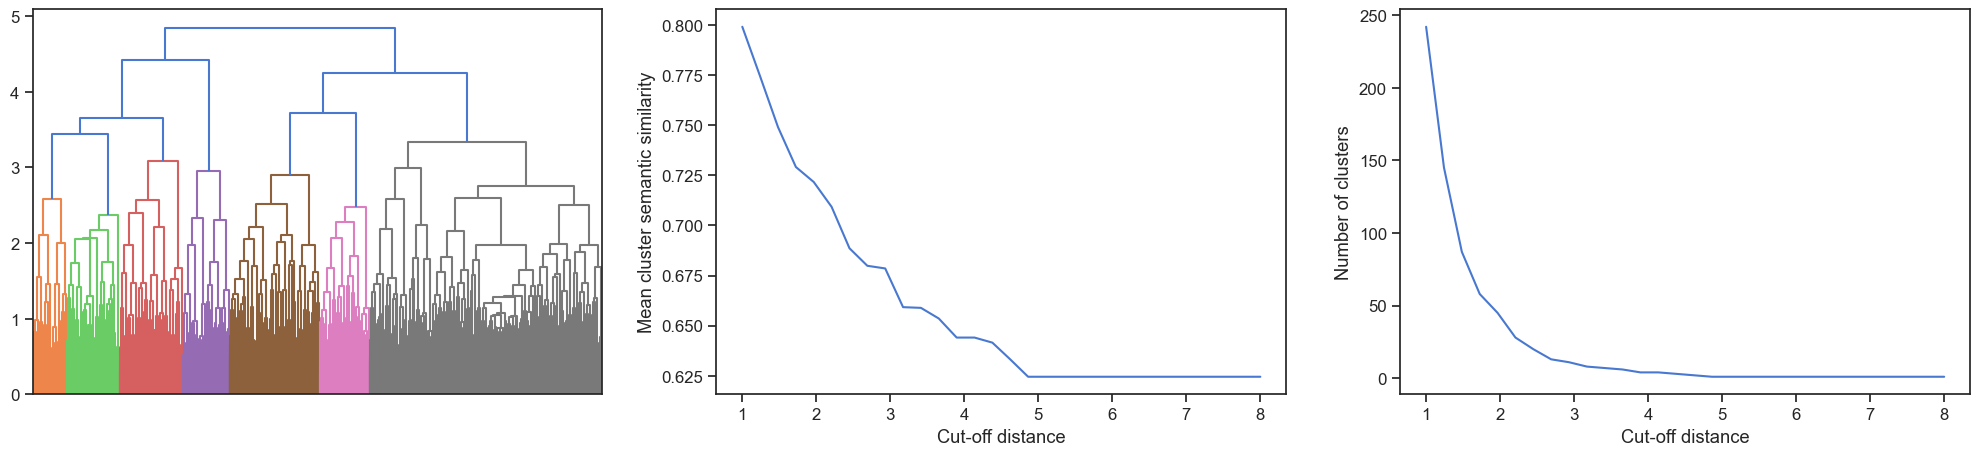

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering([sentence_transformer_embeddings_autbrick[x] for x in texts_autbrick], texts_autbrick, ax, 2.22, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

### AUT Paperclip

Cluster 14
['compass', 'puzzlesolving', 'desk toy', 'rattle', 'kind armor', 'upholstery tension', 'accupunture', 'making compass', 'mini mobile', 'narrow slot', 'confetti', 'round', 'unmuting microphone', 'for break in', 'clover', 'square', 'make ring niece nephew', 'prevent pidgeons from entering balcony', 'reach', 'confetti popper', 'throw on ground', 'guard', 'sound effect movie', 'buy', 'notes', 'wind chime holder', 'throw at people', 'wobbly chair support', 'bird fat ball hanger', 'paper curl fixer', 'untraceable', 'minisculpture', 'minijavelin', 'curl hair', 'robot arm', 'experiment creativity', 'magic tricks', 'science experiment tool', 'tiny whisk', 'ring puller', 'typing', 'money', 'freckles', 'paper doll', 'latch keeper', 'defeated', 'counting competition', 'confirm', 'twist', 'popping pimple', 'squeezing pimple', 'perfect makeup lines', 'faced problem  creative', 'arrowhead', 'play game', 'spit', 'learning tool', 'performing magic tricks', 'quay', 'trail to find way back', '

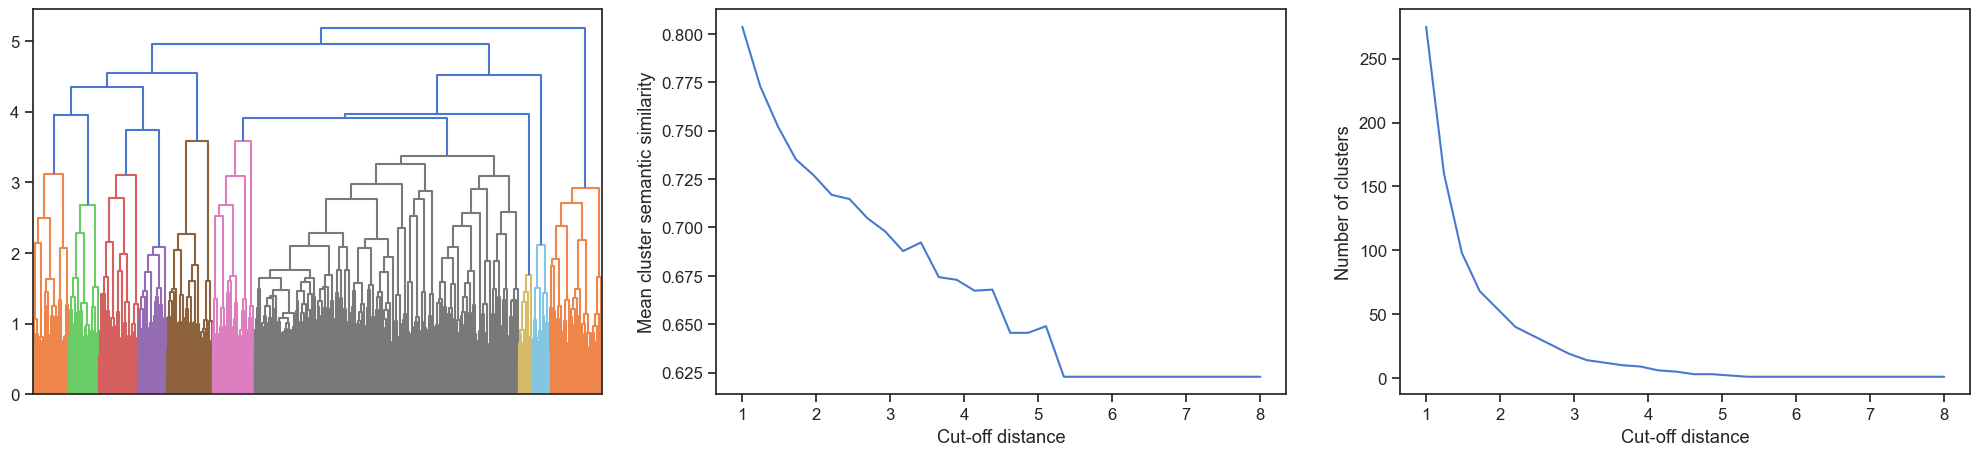

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autpaperclip, cluster_to_response_autpaperclip, num_clusters_autpaperclip, minsim_autpaperclip = perform_hierarchicalClustering([sentence_transformer_embeddings_autpaperclip[x] for x in texts_autpaperclip], texts_autpaperclip, ax, 2.6, printclusters)
print("Num clusters =", num_clusters_autpaperclip)
print(np.min(list(minsim_autpaperclip.values())), np.mean(list(minsim_autpaperclip.values())))

### Verbal Fluency

Cluster 9
['elephant seal', 'sloth', 'zoo', 'hippopotamus shrew', 'african buffalo', 'rhinoceros', 'bison', 'orangutan', 'gazelle', 'eland', 'newt', 'chetlander', 'african elephant', 'toucan', 'llama', 'caracal', 'armadillo', 'oryx', 'black rhinoceros', 'dinosaur', 'elephant', 'unicorn', 'pony', 'flamingo', 'hippopotamus fish', 'cape buffalo', 'penguin', 'hyena', 'capybara', 'walrus', 'ocelot', 'hippo', 'tyrannosaurus', 'zebra', 'wildebeest', 'jackal', 'kudu', 'rhino', 'alpaca', 'tapir', 'caiman', 'duiker', 'hippopotamus', 'narwhal', 'chupacabra', 'tarsier', 'salamander', 'buffalo', 'camel', 'shrew', 'piranha', 'dromedary', 'mongoose', 'porcupine', 'pangolin', 'meerkat', 'chameleon', 'quokka']

Cluster 2
['hamsters', 'rat', 'hog', 'guineapig', 'gray mouse', 'dog cat foot muffler owl nature mouse protect wild elephant tiger horse', 'guinea pig', 'cat dog lion tiger parrot monkey human food cows milk eggs hamster', 'mammal', 'pig', 'rodents', 'potbellied pig', 'dog cat monkey rat mouse h

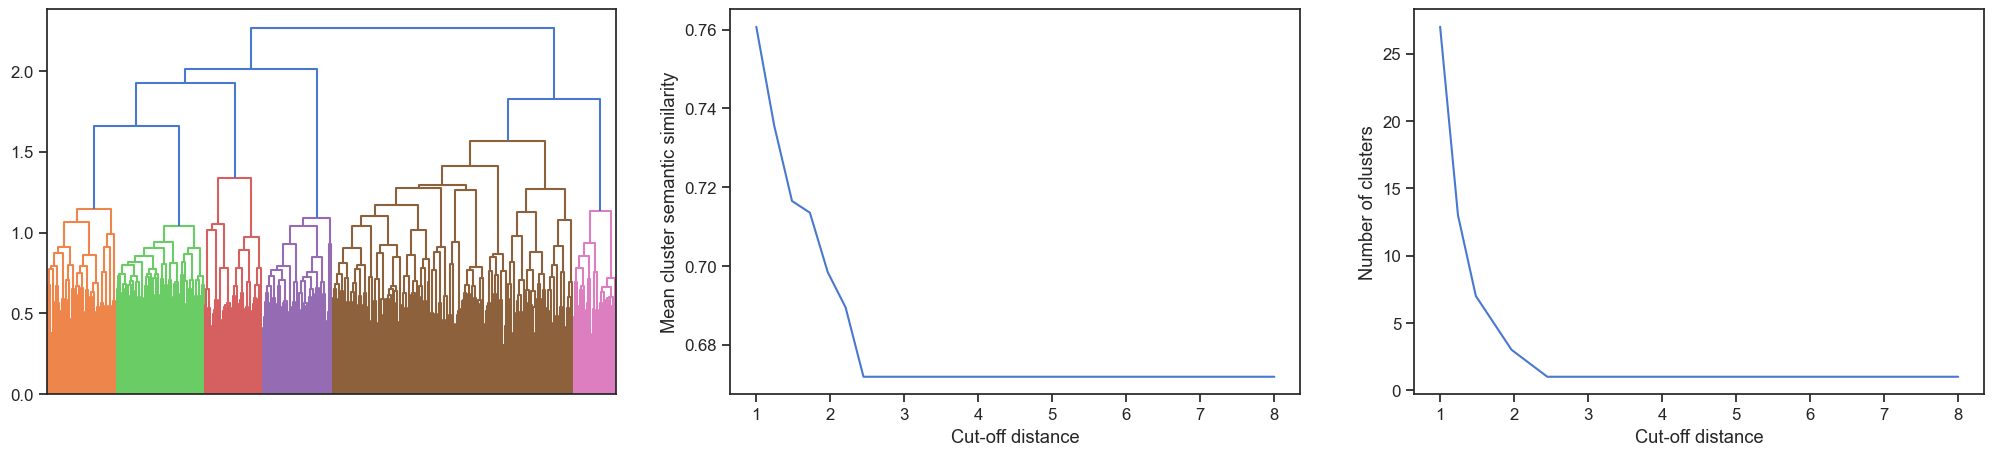

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering([sentence_transformer_embeddings_vf[x] for x in texts_vf], texts_vf, ax, 1.14, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

## Write Category, Semantic Similarity, Jump

#### Jump Procedure
<img src="../figures/jump_procedure.png" width="200">

In [13]:
def write_category_SS_jump_filterorder0(data):
    # write category using response_to_cluster
    data.loc[data["task"] == 2, "category"] = data[data["task"] == 2]["response"].apply(lambda x: response_to_cluster_autbrick.get(x))
    data.loc[data["task"] == 3, "category"] = data[data["task"] == 3]["response"].apply(lambda x: response_to_cluster_autpaperclip.get(x))
    data.loc[data["task"] == 1, "category"] = data[data["task"] == 1]["response"].apply(lambda x: response_to_cluster_vf.get(x))

    # write semantic similarity using calculate_cosine_similarity
    data.loc[data["task"] == 2, 'SS'] = data[data["task"] == 2].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autbrick.get(row['response']), sentence_transformer_embeddings_autbrick.get(row['previous_response'])), axis=1)
    data.loc[data["task"] == 3, 'SS'] = data[data["task"] == 3].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autpaperclip.get(row['response']), sentence_transformer_embeddings_autpaperclip.get(row['previous_response'])), axis=1)
    data.loc[data["task"] == 1, 'SS'] = data[data["task"] == 1].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_vf.get(row['response']), sentence_transformer_embeddings_vf.get(row['previous_response'])), axis=1)

    # write jump as described in Figure above
    data["category"] = data["category"].astype(int)
    data["jump_cat"] = (~(data["category"].diff() == 0)).astype(int)
    data["jump_SS"] = (data["SS"] < 0.8).astype(int)
    data['jump'] = data["jump_cat"] & data["jump_SS"]

    data = data[data["order"] > 0]      # remove the first response

    return data

data_humans = write_category_SS_jump_filterorder0(data_humans)
data_LLMs = write_category_SS_jump_filterorder0(data_LLMs)

## Evaluate Jump Goodness

In [14]:
TP = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == 1) & (data_humans["jump"] == 1)])
TN = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == '0') & (data_humans["jump"] == 0)])
FP = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == '0') & (data_humans["jump"] == 1)])
FN = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == 1) & (data_humans["jump"] == 0)])

print(TP, TN, FP, FN)

# check jump goodness - higher the better -- TPR
print("TPR =", TP/(TP + FN))

# check jump goodness - higher the better -- TNR
print("TNR =", TN/(TN + FP))

# check jump goodness - lower the better -- FPR
print("FPR =", FP/(FP + TN))

# check jump goodness - lower the better -- FNR
print("FNR =", FN/(TP + FN))

2386 197 41 636
TPR = 0.7895433487756452
TNR = 0.8277310924369747
FPR = 0.1722689075630252
FNR = 0.21045665122435472


## Write Originality

In [15]:
autbrick_scored = pd.read_csv("../csvs/autbrick_scored.csv")
autpaperclip_scored = pd.read_csv("../csvs/autpaperclip_scored.csv")
data_humans.loc[data_humans["task"] == 2, "originality"] = data_humans["response"].map(autbrick_scored.set_index('response')['originality'].to_dict())
data_humans.loc[data_humans["task"] == 3, "originality"] = data_humans["response"].map(autpaperclip_scored.set_index('response')['originality'].to_dict())
data_LLMs.loc[data_LLMs["task"] == 2, "originality"] = data_LLMs["response"].map(autbrick_scored.set_index('response')['originality'].to_dict())
data_LLMs.loc[data_LLMs["task"] == 3, "originality"] = data_LLMs["response"].map(autpaperclip_scored.set_index('response')['originality'].to_dict())

## Get Jump Profiles

In [16]:
# If jumps are [1,0,1], jump profile is [1,1,2] 
data_humans["jump_profile"] = data_humans.groupby(["pid", "task"])["jump"].cumsum()
data_LLMs["jump_profile"] = data_LLMs.groupby(["task", "pid"])["jump"].cumsum()

In [17]:
# The csvs created could be minorly different based on OS & software versions, therefore loading my csvs for reproducibility
data_humans = pd.read_csv("../csvs/data_humans.csv")
data_LLMs = pd.read_csv("../csvs/data_LLMs.csv")

# Analysis

## 1. Participant Clustering: Number of cumulative jumps profile
## Result Sections: Participant Clusters, LLM Assignments

In [18]:
data_humans_clustering = data_humans.groupby(["pid", "task"]).filter(lambda x: len(x) >= num_resp)      # only consider responses with atleast num_resp responses
data_humans_clustering = data_humans_clustering[data_humans_clustering["order"] <= num_resp]            # only consider exactly num_resp responses

data_LLMs_clustering = data_LLMs.groupby(["pid", "task"]).filter(lambda x: len(x) >= num_resp)          # only consider responses with atleast num_resp responses
data_LLMs_clustering = data_LLMs_clustering[data_LLMs_clustering["order"] <= num_resp]                  # only consider exactly num_resp responses
data_LLMs_clustering = data_LLMs_clustering[~((data_LLMs_clustering["task"] == 1) & (data_LLMs_clustering["model"].isin(["NousResearch/Nous-Hermes-2-Mistral-7B-DPO", "palm/text-bison@002"])))]    # remove NousResearch and Palm for VF as they only output animals in alphabetical order

Task = 2
number of participants clustered = 97
%s of participants clustered into each group = [19.587628865979383, 25.773195876288657, 54.63917525773196]
Task = 3
number of participants clustered = 103
%s of participants clustered into each group = [22.330097087378643, 40.77669902912621, 36.89320388349515]
Task = 1
number of participants clustered = 195
%s of participants clustered into each group = [38.46153846153847, 18.974358974358974, 42.56410256410256]


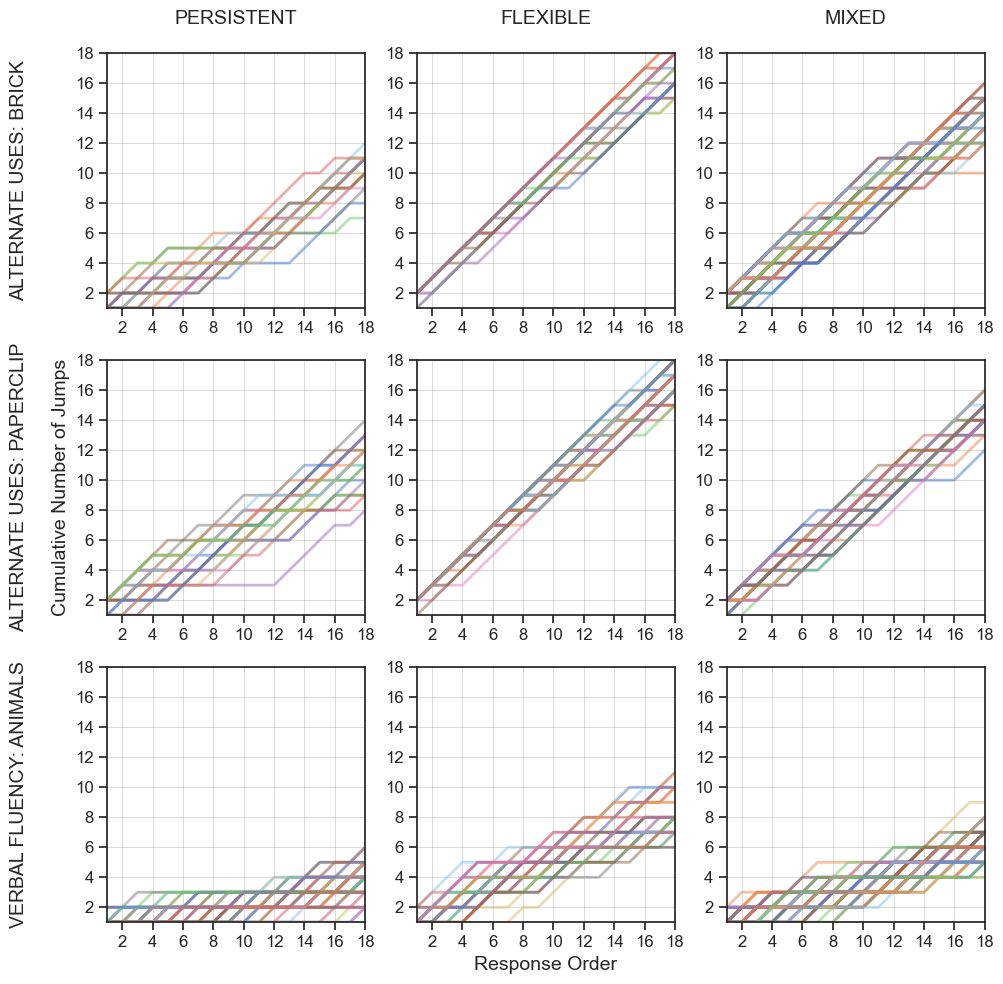

In [19]:
def participant_clustering_cumjumps(data, data_test):       # Cluster human data, assign LLM data
    num_clusters = 3
    _, ax = plt.subplots(3, num_clusters, figsize=(10.2, 10))
    task_to_index = {2:0, 3:1, 1:2}

    for task in [2, 3, 1]:
        pid_to_cumulative_jumps_profile = data[data["task"] == task].groupby("pid").agg(list)["jump_profile"].to_dict()
        data_to_cluster = np.array(list(pid_to_cumulative_jumps_profile.values()))
        pid_to_cumulative_jumps_profile_test = data_test[data_test["task"] == task].groupby("pid").agg(list)["jump_profile"].to_dict()
        data_to_cluster_test = np.array(list(pid_to_cumulative_jumps_profile_test.values()))
        
        kmeans = perform_KMeans(data_to_cluster, num_clusters)
        labels = kmeans.labels_
        predictions = kmeans.predict(data_to_cluster_test)

        # For visualisation purposes:
        cl1meanjumps = sum(data_to_cluster[labels == 0, -1])/len(data_to_cluster[labels == 0, -1])
        cl2meanjumps = sum(data_to_cluster[labels == 1, -1])/len(data_to_cluster[labels == 1, -1])
        cl3meanjumps = sum(data_to_cluster[labels == 2, -1])/len(data_to_cluster[labels == 2, -1])
        sortedjumps = np.argsort([cl1meanjumps, cl2meanjumps, cl3meanjumps])
        d = {0:sortedjumps[0], 1:sortedjumps[2], 2:sortedjumps[1]}
        d_ = {v: k for k, v in d.items()}  

        print("Task =", task)
        print("number of participants clustered =", len(labels))
        print("%s of participants clustered into each group =", [sum(labels == d[0]) / len(labels) * 100, sum(labels == d[1]) / len(labels) * 100, sum(labels == d[2]) / len(labels) * 100])
        
        cluster_names = {0:"PERSISTENT\n", 1: "FLEXIBLE\n", 2: "MIXED\n"}

        # Plotting
        for i in range(num_clusters):
            indices = np.where(labels == d[i])[0]
            for seq in data_to_cluster[indices]:
                ax[task_to_index[task], i].plot(seq, linewidth=2, alpha=0.5)
            ax[task_to_index[task], i].grid(linewidth=0.5)
            ax[task_to_index[task], i].set_xlim(0,num_resp - 1)
            ax[task_to_index[task], i].set_xticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
            ax[task_to_index[task], i].set_ylim(0,num_resp - 1)
            ax[task_to_index[task], i].set_yticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
            if task == 2:
                ax[task_to_index[task], i].set_title(cluster_names[i], fontsize=14)
            if i == 1 and task == 1:
                ax[task_to_index[task], i].set_xlabel("Response Order", fontsize=14)
            if i == 0 and task == 2:
                ax[task_to_index[task], i].set_ylabel("ALTERNATE USES: BRICK\n\n", fontsize=14)
            if i == 0 and task == 3:
                ax[task_to_index[task], i].set_ylabel("ALTERNATE USES: PAPERCLIP\n\nCumulative Number of Jumps", fontsize=14)
            if i == 0 and task == 1:
                ax[task_to_index[task], i].set_ylabel("VERBAL FLUENCY: ANIMALS\n\n", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.2)

        data.loc[data["task"] == task, "participant_cluster"] = data[data["task"] == task]["pid"].map(dict(zip(np.array(list(pid_to_cumulative_jumps_profile.keys())), [d_[l] for l in labels])))
        data_test.loc[data_test["task"] == task, "participant_cluster"] = data_test[data_test["task"] == task]["pid"].map(dict(zip(np.array(list(pid_to_cumulative_jumps_profile_test.keys())), [d_[l] for l in predictions])))

    plt.show()

    return data, data_test

data_humans_clustering, data_LLMs_clustering = participant_clustering_cumjumps(data_humans_clustering, data_LLMs_clustering)

### LLM assignments

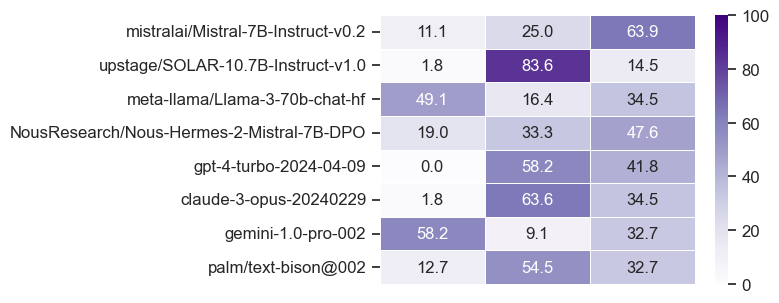

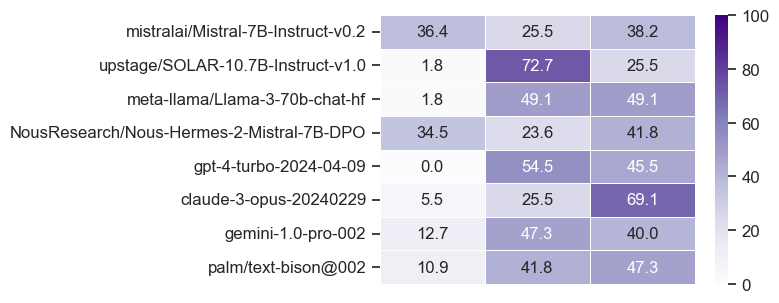

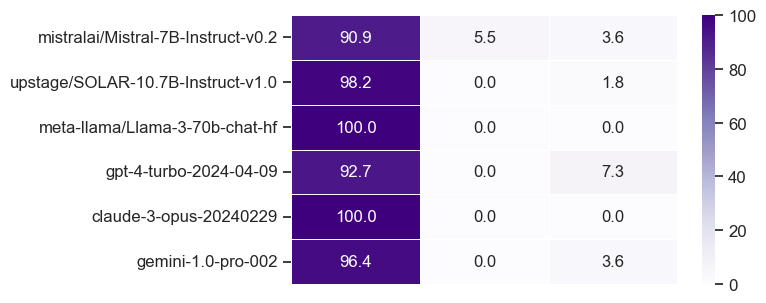

In [20]:
def get_llm_assignments(data):
    group_counts_task2 = data[data["task"] == 2].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]
    group_counts_task3 = data[data["task"] == 3].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]
    group_counts_task1 = data[data["task"] == 1].groupby("pid").head(1).groupby(["model", "participant_cluster"]).count()["jump_profile"]

    model_order_task2 = ["mistralai/Mistral-7B-Instruct-v0.2", "upstage/SOLAR-10.7B-Instruct-v1.0", "meta-llama/Llama-3-70b-chat-hf", "NousResearch/Nous-Hermes-2-Mistral-7B-DPO", \
                "gpt-4-turbo-2024-04-09", "claude-3-opus-20240229", "gemini-1.0-pro-002", "palm/text-bison@002"]
    model_order_task3 = model_order_task2
    model_order_task1 = ["mistralai/Mistral-7B-Instruct-v0.2", "upstage/SOLAR-10.7B-Instruct-v1.0", "meta-llama/Llama-3-70b-chat-hf", \
                "gpt-4-turbo-2024-04-09", "claude-3-opus-20240229", "gemini-1.0-pro-002"]

    group_counts_task2 = group_counts_task2.reindex(pd.MultiIndex.from_product([model_order_task2, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    group_counts_task3 = group_counts_task3.reindex(pd.MultiIndex.from_product([model_order_task3, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    group_counts_task1 = group_counts_task1.reindex(pd.MultiIndex.from_product([model_order_task1, [0,1,2]], names=['model', 'participant_cluster']), fill_value=0)
    for_heatmap_task2 = (100 * group_counts_task2 / group_counts_task2.groupby(level=0).sum()).reset_index()
    for_heatmap_task3 = (100 * group_counts_task3 / group_counts_task3.groupby(level=0).sum()).reset_index()
    for_heatmap_task1 = (100 * group_counts_task1 / group_counts_task1.groupby(level=0).sum()).reset_index()

    # Plotting
    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task2.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task3.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

    plt.figure(figsize=(8, 3.2))
    ax = sns.heatmap(for_heatmap_task1.pivot_table(index="model", columns="participant_cluster", values="jump_profile", sort=False), annot=True, cmap='Purples', fmt=".1f", linewidths=.5, vmin=0, vmax=100)
    plt.ylabel("")
    ax.xaxis.set_visible(False)
    plt.tight_layout()

get_llm_assignments(data_LLMs_clustering)       # create LLM assignment heatmaps

### Humans vs Models num_jumps

In [21]:
def find_num_jumps(data):
    num_jumps = data.groupby("pid").tail(1)["jump_profile"]
    return num_jumps

def humans_vs_models_numjumps(data_humans, data_LLMs):
    humans_num_jumps_task2, humans_num_jumps_task3, humans_num_jumps_task1 = [find_num_jumps(data_humans[data_humans["task"] == 2]), find_num_jumps(data_humans[data_humans["task"] == 3]), find_num_jumps(data_humans[data_humans["task"] == 1])]
    LLMs_num_jumps_task2, LLMs_num_jumps_task3, LLMs_num_jumps_task1 = [find_num_jumps(data_LLMs[(data_LLMs["task"] == 2)]), find_num_jumps(data_LLMs[data_LLMs["task"] == 3]), find_num_jumps(data_LLMs[data_LLMs["task"] == 1])]

    print("Task 2 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task2, LLMs_num_jumps_task2))
    print("Task 3 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task3, LLMs_num_jumps_task3))
    print("Task 1 num_jumps humans vs LLMs:", ttest_ind(humans_num_jumps_task1, LLMs_num_jumps_task1))

humans_vs_models_numjumps(data_humans_clustering, data_LLMs_clustering)

Task 2 num_jumps humans vs LLMs: Ttest_indResult(statistic=-0.8460089801847719, pvalue=0.397967531947087)
Task 3 num_jumps humans vs LLMs: Ttest_indResult(statistic=-0.5631034159950725, pvalue=0.5735977568639479)
Task 1 num_jumps humans vs LLMs: Ttest_indResult(statistic=20.586859113844074, pvalue=2.043705421163027e-69)


In [22]:
def percent_jumps(data):
    print("AUT Brick Percentage Jumps =", sum(data[data["task"] == 2]["jump"]) / len(data[data["task"] == 2]["jump"]) * 100)
    print("AUT Paperclip Percentage Jumps =", sum(data[data["task"] == 3]["jump"]) / len(data[data["task"] == 3]["jump"]) * 100)
    print("Verbal Fluency Percentage Jumps =", sum(data[data["task"] == 1]["jump"]) / len(data[data["task"] == 1]["jump"]) * 100)

percent_jumps(data_humans)
percent_jumps(data_LLMs)

AUT Brick Percentage Jumps = 74.4478527607362
AUT Paperclip Percentage Jumps = 77.06006640507094
Verbal Fluency Percentage Jumps = 25.99949710837314
AUT Brick Percentage Jumps = 73.64190328017632
AUT Paperclip Percentage Jumps = 76.57799274486095
Verbal Fluency Percentage Jumps = 14.962234744035488


### Temperature Analysis

In [23]:
data_LLMs_temp = data_LLMs_clustering.groupby(["task", "pid"]).tail(1)
data_LLMs_temp['task'] = data_LLMs_temp['task'].astype('category')

#### Temperature ~ cluster

In [24]:
title = 'participant_cluster ~ temp * task'
model = smf.glm(formula='participant_cluster ~ temp * task', data=data_LLMs_temp[data_LLMs_temp["participant_cluster"].isin([0,1])][["temp", "task", "participant_cluster"]], family=sm.families.Binomial()).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

participant_cluster ~ temp * task 
          Variable  Coefficient   p-value
0       Intercept   -10.146688  0.009288
1       task[T.2]    10.941610  0.005124
2       task[T.3]    11.455735  0.003402
3            temp     7.308877  0.088901
4  temp:task[T.2]    -7.253482  0.092968
5  temp:task[T.3]    -7.548189  0.080791


#### Temperature ~ number of jumps

In [25]:
title = 'jump_profile ~ temp, for task 2'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 2][["temp", "task", "jump_profile"]]).fit()  # same even using , family=sm.families.Poisson()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 2].groupby("temp").mean()["jump_profile"].tolist()), "\n")

title = 'jump_profile ~ temp, for task 3'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 3][["temp", "task", "jump_profile"]]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 3].groupby("temp").mean()["jump_profile"].tolist()), "\n")

title = 'jump_profile ~ temp, for task 1'
model = smf.glm(formula='jump_profile ~ temp', data=data_LLMs_temp[data_LLMs_temp["task"] == 1][["temp", "task", "jump_profile"]]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)
print("Correlation:", pearsonr(np.arange(0,11)*0.1, data_LLMs_temp[data_LLMs_temp["task"] == 1].groupby("temp").mean()["jump_profile"].tolist()))

jump_profile ~ temp, for task 2 
     Variable  Coefficient   p-value
0  Intercept    12.951659  0.000000
1       temp     0.534047  0.311059
Correlation: PearsonRResult(statistic=0.3416826169073693, pvalue=0.30374714381586243) 

jump_profile ~ temp, for task 3 
     Variable  Coefficient   p-value
0  Intercept    13.568182  0.000000
1       temp     0.431818  0.175088
Correlation: PearsonRResult(statistic=0.41998822653385165, pvalue=0.1984309673346109) 

jump_profile ~ temp, for task 1 
     Variable  Coefficient       p-value
0  Intercept     0.975758  2.435431e-12
1       temp     1.193939  3.930509e-07
Correlation: PearsonRResult(statistic=0.8875134533608426, pvalue=0.00026663115520457123)


### Sanity Check: jump_profile should impact participant_cluster

In [26]:
title = 'participant_cluster ~ jump_profile + task'
model = smf.glm(formula='participant_cluster ~ jump_profile + task', data=data_LLMs_temp[data_LLMs_temp["participant_cluster"].isin([0,1])][["jump_profile", "task", "participant_cluster"]], family=sm.families.Binomial()).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

participant_cluster ~ jump_profile + task 
        Variable  Coefficient   p-value
0     Intercept   -24.415262  0.000068
1     task[T.2]   -31.464528  0.000457
2     task[T.3]   -34.488923  0.000193
3  jump_profile     4.656762  0.000124


## 2. Jump Signal Reliability and Validity
## Result Sections: Jump Signal Reliability and Validity

### Consistency Across AUT Tasks

In [27]:
data_humans_across_tasks = data_humans.groupby('pid').filter(lambda x: all(
        x[x['task'] == task].shape[0] >= num_resp for task in [2, 3]
    ))  # only keep pids with atleast num_resp responses in EACH AUT task

data_LLMs_across_tasks = data_LLMs.groupby('pid').filter(lambda x: all(
        x[x['task'] == task].shape[0] >= num_resp for task in [2, 3]
    ))  # only keep pids with atleast num_resp responses in EACH AUT task

In [28]:
print("For Humans:")
print("AUT Brick length =", len(data_humans_across_tasks[data_humans_across_tasks["task"] == 2].groupby("pid")))
print("AUT Paperclip length =" ,len(data_humans_across_tasks[data_humans_across_tasks["task"] == 3].groupby("pid")))

print("For LLMs:")
print("AUT Brick length =", len(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 2].groupby("pid")))
print("AUT Paperclip length =", len(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 3].groupby("pid")))

For Humans:
AUT Brick length = 81
AUT Paperclip length = 81
For LLMs:
AUT Brick length = 387
AUT Paperclip length = 387


In [29]:
humans_num_jumps_task2, humans_num_jumps_task3, humans_num_jumps_task1 = [find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 2]), find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 3]), find_num_jumps(data_humans_across_tasks[data_humans_across_tasks["task"] == 1])]
LLMs_num_jumps_task2, LLMs_num_jumps_task3, LLMs_num_jumps_task1 = [find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 2]), find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 3]), find_num_jumps(data_LLMs_across_tasks[data_LLMs_across_tasks["task"] == 1])]

In [30]:
corr = pearsonr(humans_num_jumps_task2, humans_num_jumps_task3)
print("Humans test-restest corr:", corr, corr.confidence_interval())
print("T-test:", ttest_ind(humans_num_jumps_task2, humans_num_jumps_task3), "\n")

corr = pearsonr(LLMs_num_jumps_task2, LLMs_num_jumps_task3)
print("LLMs test-restest corr:", corr, corr.confidence_interval())
print("T-test:", ttest_ind(LLMs_num_jumps_task2, LLMs_num_jumps_task3))

Humans test-restest corr: PearsonRResult(statistic=0.4217335892545924, pvalue=8.811726000640295e-05) ConfidenceInterval(low=0.22401243238914847, high=0.5861108158731388)
T-test: Ttest_indResult(statistic=-1.8400252033905646, pvalue=0.067617347251242) 

LLMs test-restest corr: PearsonRResult(statistic=0.2231166287064817, pvalue=9.379606232903465e-06) ConfidenceInterval(low=0.12623757830043483, high=0.3157799195724082)
T-test: Ttest_indResult(statistic=-3.697156601812993, pvalue=0.00023345699785711215)


### Validity: AUT vs VF jumping

Ttest_indResult(statistic=23.65159321408252, pvalue=4.2182216953925253e-54)
Ttest_indResult(statistic=26.600678041192523, pvalue=1.2795459693304776e-60)
Ttest_indResult(statistic=49.549494640325015, pvalue=7.56553845578359e-242)
Ttest_indResult(statistic=67.89417481309732, pvalue=0.0)


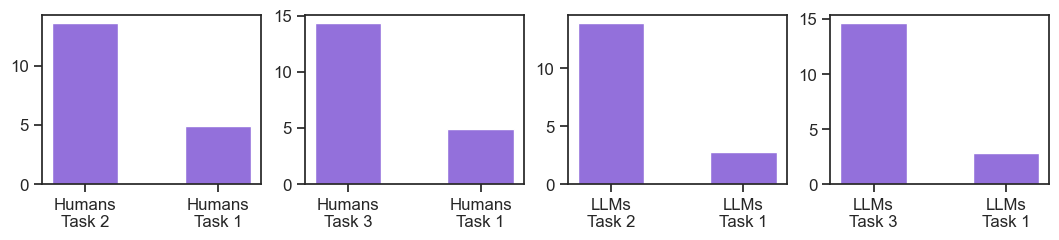

In [31]:
print(ttest_ind(humans_num_jumps_task2, humans_num_jumps_task1))
print(ttest_ind(humans_num_jumps_task3, humans_num_jumps_task1))
fig, ax = plt.subplots(1,4, figsize=(13, 2.2))
ax[0].bar(["Humans\nTask 2", "Humans\nTask 1"], [np.mean(humans_num_jumps_task2), np.mean(humans_num_jumps_task1)], color = "mediumpurple", width=0.5)
ax[1].bar(["Humans\nTask 3", "Humans\nTask 1"], [np.mean(humans_num_jumps_task3), np.mean(humans_num_jumps_task1)], color = "mediumpurple", width=0.5)

print(ttest_ind(LLMs_num_jumps_task2, LLMs_num_jumps_task1))
print(ttest_ind(LLMs_num_jumps_task3, LLMs_num_jumps_task1))
ax[2].bar(["LLMs\nTask 2", "LLMs\nTask 1"], [np.mean(LLMs_num_jumps_task2), np.mean(LLMs_num_jumps_task1)], color = "mediumpurple", width=0.5)
ax[3].bar(["LLMs\nTask 3", "LLMs\nTask 1"], [np.mean(LLMs_num_jumps_task3), np.mean(LLMs_num_jumps_task1)], color = "mediumpurple", width=0.5);

### Validity: Jump ~ RT

Ttest_indResult(statistic=-28.571945717237753, pvalue=5.216941595071701e-173)


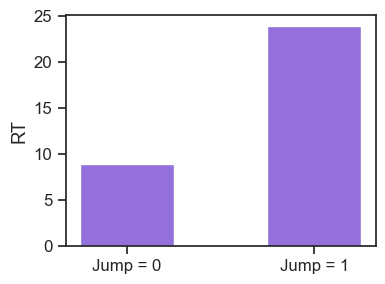

In [32]:
print(ttest_ind(data_humans[data_humans["jump"] == 0]["RT"], data_humans[data_humans["jump"] == 1]["RT"]))
plt.bar(["Jump = 0", "Jump = 1"], [np.mean(data_humans[data_humans["jump"] == 0]["RT"]), np.mean(data_humans[data_humans["jump"] == 1]["RT"])], color = "mediumpurple", width=0.5)
plt.ylabel("RT");

## 3. Originality ~ Cluster
## Result Sections: Relationship to Creativity

In [33]:
data_humans_clustering.loc[(data_humans_clustering["task"].isin([2,3])) & (pd.isnull(data_humans_clustering["originality"])), "originality"] = 2.5      # add in 2 missing originality scores
data_LLMs_clustering.loc[(data_LLMs_clustering["task"].isin([2,3])) & (pd.isnull(data_LLMs_clustering["originality"])), "originality"] = 2

data_humans_originality = data_humans_clustering[data_humans_clustering["task"].isin([2,3])]
data_LLMs_originality = data_LLMs_clustering[data_LLMs_clustering["task"].isin([2,3])]

data_humans_originality["type"] = 0     # type = 0 => humans, tyep = 1 => LLMs
data_LLMs_originality["type"] = 1
data_LLMs_originality['task'] = data_LLMs_originality['task'].astype(int)

data_humans_originality_mean_task2 = data_humans_originality[data_humans_originality["task"] == 2].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_humans_originality_mean_task2["num_jumps"] = data_humans_originality[data_humans_originality["task"] == 2].groupby(["pid"]).tail(1)["jump_profile"].tolist()
data_humans_originality_mean_task3 = data_humans_originality[data_humans_originality["task"] == 3].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_humans_originality_mean_task3["num_jumps"] = data_humans_originality[data_humans_originality["task"] == 3].groupby(["pid"]).tail(1)["jump_profile"].tolist()

data_LLMs_originality_mean_task2 = data_LLMs_originality[data_LLMs_originality["task"] == 2].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_LLMs_originality_mean_task2["num_jumps"] = data_LLMs_originality[data_LLMs_originality["task"] == 2].groupby(["pid"]).tail(1)["jump_profile"].tolist()
data_LLMs_originality_mean_task3 = data_LLMs_originality[data_LLMs_originality["task"] == 3].groupby(["pid"]).mean()[["originality", "participant_cluster", "task", "type"]].reset_index()
data_LLMs_originality_mean_task3["num_jumps"] = data_LLMs_originality[data_LLMs_originality["task"] == 3].groupby(["pid"]).tail(1)["jump_profile"].tolist()

data_humans_originality_mean = pd.concat([data_humans_originality_mean_task2, data_humans_originality_mean_task3], axis=0, ignore_index=True)
data_LLMs_originality_mean = pd.concat([data_LLMs_originality_mean_task2, data_LLMs_originality_mean_task3], axis=0, ignore_index=True)

In [34]:
data_humans_originality_mean['task'] = data_humans_originality_mean['task'].astype('category')
data_humans_originality_mean['type'] = data_humans_originality_mean['type'].astype('category')
data_LLMs_originality_mean['task'] = data_LLMs_originality_mean['task'].astype('category')
data_LLMs_originality_mean['type'] = data_LLMs_originality_mean['type'].astype('category')

Ttest_indResult(statistic=-1.107910457580006, pvalue=0.27420506593198984)
Ttest_indResult(statistic=-1.3123577580494925, pvalue=0.19416078247264676)


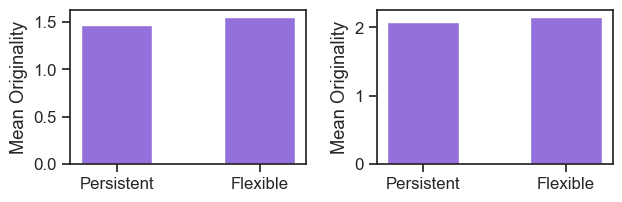

num_jumps ~ originality, for task 2 
       Variable  Coefficient       p-value
0    Intercept     9.718710  8.553563e-09
1  originality     2.130266  5.377417e-02 

num_jumps ~ originality, for task 3 
       Variable  Coefficient   p-value
0    Intercept     8.697303  0.000205
1  originality     2.325803  0.033627


In [35]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
fig.subplots_adjust(wspace=0.3)

# human task2 cluster 0 vs 1
print(ttest_ind(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 2)]["originality"], data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1)  & (data_humans_originality_mean["task"] == 2)]["originality"]))
ax[0].bar(["Persistent", "Flexible"], [np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 2)]["originality"]), np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1) & (data_humans_originality_mean["task"] == 2)]["originality"])], color = "mediumpurple", width=0.5)
ax[0].set_ylabel("Mean Originality");

# human task3 cluster 0 vs 1
print(ttest_ind(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 3)]["originality"], data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1)  & (data_humans_originality_mean["task"] == 3)]["originality"]))
ax[1].bar(["Persistent", "Flexible"], [np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 0) & (data_humans_originality_mean["task"] == 3)]["originality"]), np.mean(data_humans_originality_mean[(data_humans_originality_mean["participant_cluster"] == 1) & (data_humans_originality_mean["task"] == 3)]["originality"])], color = "mediumpurple", width=0.5)
ax[1].set_ylabel("Mean Originality");

plt.show()

title = 'num_jumps ~ originality, for task 2'
model = smf.glm(formula='num_jumps ~ originality', data=data_humans_originality_mean[data_humans_originality_mean["task"] == 2]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

title = 'num_jumps ~ originality, for task 3'
model = smf.glm(formula='num_jumps ~ originality', data=data_humans_originality_mean[data_humans_originality_mean["task"] == 3]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df)

Ttest_indResult(statistic=-10.886473060666118, pvalue=8.421561519994597e-23)
Ttest_indResult(statistic=-2.5616574347887773, pvalue=0.011024509263906667)


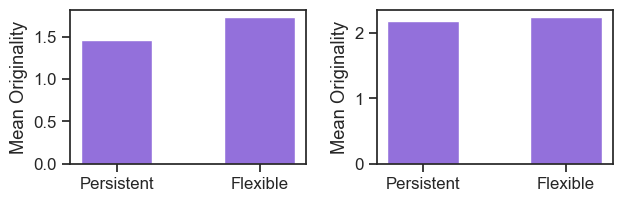

num_jumps ~ originality, for task 2 
       Variable  Coefficient       p-value
0    Intercept     3.873036  6.000817e-04
1  originality     5.667729  5.578652e-17 

num_jumps ~ originality, for task 3 
       Variable  Coefficient       p-value
0    Intercept    10.065874  2.939126e-12
1  originality     1.651105  9.743666e-03 



In [36]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
fig.subplots_adjust(wspace=0.3)

# LLM task2 cluster 0 vs 1
print(ttest_ind(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 2)]["originality"], data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1)  & (data_LLMs_originality_mean["task"] == 2)]["originality"]))
ax[0].bar(["Persistent", "Flexible"], [np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 2)]["originality"]), np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1) & (data_LLMs_originality_mean["task"] == 2)]["originality"])], color = "mediumpurple", width=0.5)
ax[0].set_ylabel("Mean Originality");

# LLM task3 cluster 0 vs 1
print(ttest_ind(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 3)]["originality"], data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1)  & (data_LLMs_originality_mean["task"] == 3)]["originality"]))
ax[1].bar(["Persistent", "Flexible"], [np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 0) & (data_LLMs_originality_mean["task"] == 3)]["originality"]), np.mean(data_LLMs_originality_mean[(data_LLMs_originality_mean["participant_cluster"] == 1) & (data_LLMs_originality_mean["task"] == 3)]["originality"])], color = "mediumpurple", width=0.5)
ax[1].set_ylabel("Mean Originality");
plt.show()

title = 'num_jumps ~ originality, for task 2'
model = smf.glm(formula='num_jumps ~ originality', data=data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 2]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

title = 'num_jumps ~ originality, for task 3'
model = smf.glm(formula='num_jumps ~ originality', data=data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 3]).fit()
results_df = pd.DataFrame({'Variable': model.params.index, 'Coefficient': model.params.values, 'p-value': model.pvalues.values})
print(title, "\n", results_df, "\n")

### Type (human or LLM) vs mean originality

In [37]:
print(ttest_ind(data_humans_originality_mean[data_humans_originality_mean["task"] == 2]["originality"], data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 2]["originality"]))
print(ttest_ind(data_humans_originality_mean[data_humans_originality_mean["task"] == 3]["originality"], data_LLMs_originality_mean[data_LLMs_originality_mean["task"] == 3]["originality"]))

Ttest_indResult(statistic=-5.495749472699555, pvalue=6.314189618407061e-08)
Ttest_indResult(statistic=-6.622307304220897, pvalue=8.543240133079917e-11)


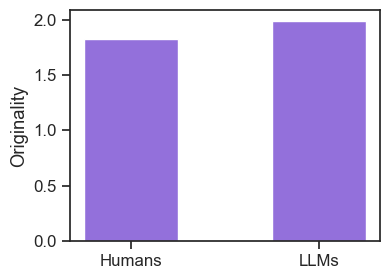

In [38]:
plt.bar(["Humans", "LLMs"], [np.mean(data_humans_originality_mean["originality"]), np.mean(data_LLMs_originality_mean.iloc[np.random.permutation(len(data_LLMs_originality_mean))[:len(data_humans_originality_mean)]]["originality"])], color = "mediumpurple", width=0.5)
plt.ylabel("Originality");
plt.show()

## Visualise Embeddings

### TSNE

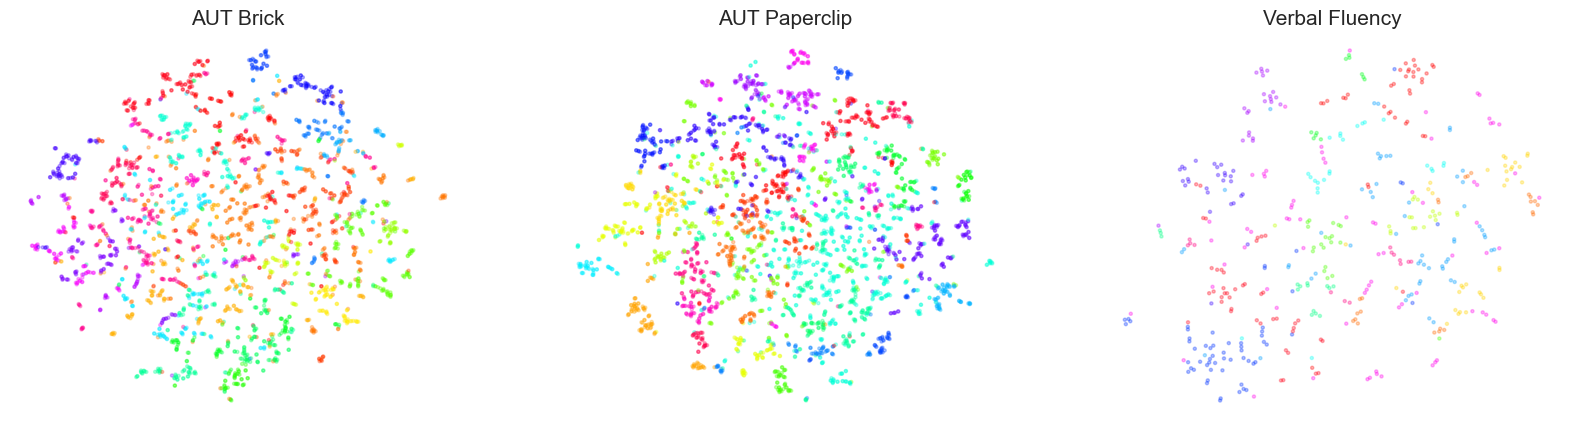

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

make_TSNE(np.array([sentence_transformer_embeddings_autbrick[x] for x in texts_autbrick]), texts_autbrick, ax[0], [response_to_cluster_autbrick[t] for t in texts_autbrick])
ax[0].set_title('AUT Brick', fontsize=15)

make_TSNE(np.array([sentence_transformer_embeddings_autpaperclip[x] for x in texts_autpaperclip]), texts_autpaperclip, ax[1], [response_to_cluster_autpaperclip[t] for t in texts_autpaperclip])
ax[1].set_title('AUT Paperclip', fontsize=15)

make_TSNE(np.array([sentence_transformer_embeddings_vf[x] for x in texts_vf]), texts_vf, ax[2], [response_to_cluster_vf[t] for t in texts_vf])
ax[2].set_title('Verbal Fluency', fontsize=15);